<a href="https://colab.research.google.com/github/osvlandi/AI_for_medicine/blob/main/diagnosis/week1-disease-detection/Image_preprocessing_for_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image preprocessing for AI

This notebook explores medical image manipulation using Python and performing essential preprocessing steps to prepare the data for training AI models.

I'll be using the [ChestX-ray8](https://arxiv.org/abs/1705.02315) dataset, a publicly available collection of chest X-ray images, as our working dataset. It contains thousands of labeled images and is widely used for research in automated disease detection.

### 🩻 Chest X-ray Examples

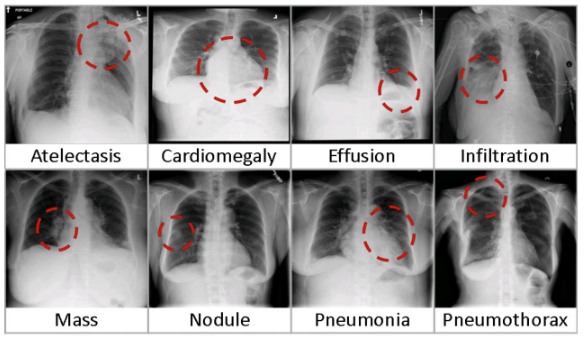

In [5]:
from IPython.display import Image, display, Markdown

display(Markdown("### 🩻 Chest X-ray Examples"))
display(Image(filename="imagem.png"))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.listdir()

['.config', 'drive', 'imagem.png', 'sample_data']